# Hand Gesture recognition using CNN and data Augmentation

This project aims to showcase the use of Convolutional neural networks (CNN) for Hand Gesture recognition.  
The dataset used is contains several images that correspondes to different classes. Therfore it's a classification problem.

Let's first load the required libraries :  
**os** : For navigating directories  
**numpy** : for matrix manipulation in Python  
**pyplot** from matplotlib : for visualisations  
**h5py** : to handle h5 files (dataset and pre-trained models)  
**sklearn** : for the "one hot encoding" and "train/test split" functions  
**keras** : to build and train the CNN

The data used in this notebook was provided in Andrew Ng's deep learning course specialization.

In [1]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import h5py

import tensorflow as tf
from tensorflow.keras import layers, models

from IPython.display import clear_output
np.random.seed(10)

The dataset is stored in the "dataset" directory, which contains the

In [2]:
path = ".\\datasets\\"
ds_list = os.listdir(path)
ds_list

['test_signs.h5', 'train_signs.h5']

Let's load the train set first

In [3]:
import h5py
f = h5py.File(join(path, 'train_signs.h5'), 'r')
list(f.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [4]:
list_cls = f['list_classes']
x = np.array(f['train_set_x'])
y = np.array(f['train_set_y'])

In [5]:
print(x.shape)
print(y.shape)

(1080, 64, 64, 3)
(1080,)


Let's visualize a sample image

The sign corresponds : 4


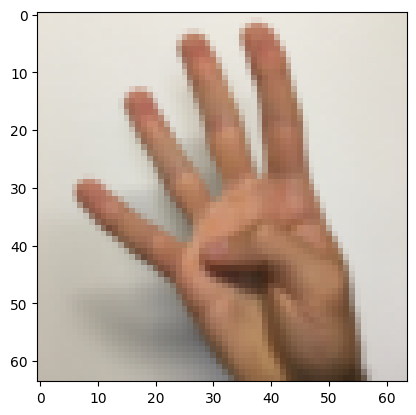

In [48]:
idx = np.random.randint(0, high=1080)
img = x[idx]
print("The sign corresponds :",  y[idx])
plt.imshow(img)

## Data augmentation

We want our algorithm to determin the number wichever the hand orientation. Therefore, we will use fips and rotations to increase the number of smalples with different orientations.

In [49]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [50]:
image = np.expand_dims(img, 0)

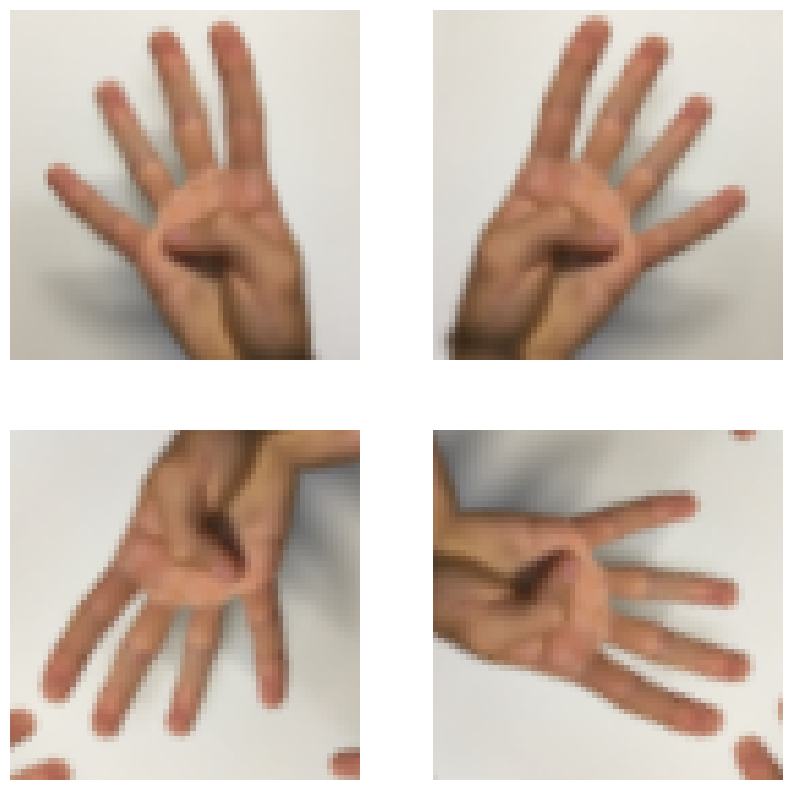

In [51]:
plt.figure(figsize=(10, 10))
for i in range(4):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_image.numpy()[0].astype(np.uint8))
    plt.axis("off")

we can some distortion as other fingers or forms appear in the augmented images, but this can allo the algorithm more robust.

In [52]:
data_augmentation.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (1, 64, 64, 3)            0         
                                                                 
 random_rotation_3 (RandomRo  (1, 64, 64, 3)           0         
 tation)                                                         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [53]:
data_augmentation.compile()

In [54]:
aug_x = x
aug_y = y

for i in range(3):
    aug_tmp = data_augmentation(x)
    aug_x = np.append(aug_x, aug_tmp, axis = 0)
    aug_y = np.append(aug_y, y, axis = 0)


The new dataset now contains 4320 images.

In [55]:
print(aug_x.shape, aug_y.shape)

(4320, 64, 64, 3) (4320,)


## Preprocessing

### X data

The images are stacked in a single numpy array **x**.  
It's common practice in deep learning to normalize the input in order to speed up training.  
Given the inputs are RGB images, every pixel is encoded in a vector of 3 values between 0 and 255.  
A simple way to normalize image inputs is to divide every pixel value by 255, providing input values between 0 and 1.

In [56]:
#x_data = x /255.0
x_data = aug_x /255.0

### Y data

Let's now take a look on the classes

In [57]:
list(list_cls)

[0, 1, 2, 3, 4, 5]

Every element in y is a number between 0 and 5, corresponding to the gesture proposed.
Given that we have 6 distinct classes, we will need to use a softmax function in the ouput layer of our CNN.  
To be able to train the CNN with a softmax layer, we will need to encode the classes difrrently. We will use "One hot encoding" which transformes each class in a vector of ones and zeros:  
**Examples :**  
y = 0   becomes  y = [1, 0, 0, 0, 0, 0]  
y = 5   becomes  y = [0, 0, 0, 0, 0, 1]  

In [59]:
from sklearn.preprocessing import OneHotEncoder

the firs label example contains the number : 5


In [71]:
ohe = OneHotEncoder()
ohe.fit(y_array)
y_data = ohe.transform(y_array).toarray()
y_array = np.array(aug_y)
y_array = np.expand_dims(y_array, axis=1)
print( "Before transformation, the first label example contains :" , y_array[0][0])
print( "Before transformation, the first label example contains :" , y_data[0])

Before transformation, the first label example contains : 5
Before transformation, the first label example contains : [0. 0. 0. 0. 0. 1.]


### Training test split

We will split the training data into training and validation sets. the first set is used for training, and the second is to monitor the accuracy of the predictions on a set of images that were not used in training.For that we will use the *train_test_split* function.  
It's important also that all classes are represented equally in both sets, hence the use of *stratify*.  

In [72]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.2, stratify=y_array)

# Model

Using Keras, we build our CNN model. This model is inspired from VGG models, combining Convolution and Pooling layers with final a fully connected layer as output.

In [73]:
# model 4 : 96%
CNN = models.Sequential()
CNN.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.Conv2D(32, (3,3), activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.MaxPooling2D((2, 2), strides=2))
CNN.add(layers.Conv2D(32, (3,3), activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.MaxPooling2D((2, 2), strides=2))
CNN.add(layers.Conv2D(64, (3,3), activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.MaxPooling2D((2, 2), strides=2))
CNN.add(layers.Conv2D(64, (3,3), activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.Conv2D(64, (3,3), activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.MaxPooling2D((2, 2), strides=2))
CNN.add(layers.Flatten())
CNN.add(layers.Dense(32, activation='relu'))
CNN.add(layers.Dropout(0.1))
CNN.add(layers.Dense(6, activation='softmax'))

The two main layers used are convolution and pooling where :
* For Convolutions (CONV2D) we define the number of filters (or kernels), usually 3x3 filters. When trained, these filters will extacrt important features for the classification.
* Pooling layerooling2D), usually 2x2 with a stride of 2, helps divide the size of the input.  

Through a combination of both layers, we end up with a layer that gives a (1,1,64) output. This allows a simple transition to a fully connected layer without introducing new parameters.  
Then the output layer has 6 cells, each one corresponding to a class.

In [74]:
CNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                      

Then we define the optimizer, the loss function and the metric to monitor:  

In [76]:
CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Finally, we train the model, using the traning set, and monitor it using the validation set :

In [77]:
history = CNN.fit(x_train, y_train, epochs=40, batch_size = 64, validation_data=(x_val, y_val))

Epoch 1/40
54/54 [==============================] - 21s 361ms/step - loss: 1.7933 - accuracy: 0.1664 - val_loss: 1.7914 - val_accuracy: 0.1586
Epoch 2/40
54/54 [==============================] - 21s 396ms/step - loss: 1.7885 - accuracy: 0.1791 - val_loss: 1.7917 - val_accuracy: 0.1667
Epoch 3/40
54/54 [==============================] - 21s 385ms/step - loss: 1.7915 - accuracy: 0.1626 - val_loss: 1.7898 - val_accuracy: 0.1505
Epoch 4/40
54/54 [==============================] - 20s 374ms/step - loss: 1.7257 - accuracy: 0.2156 - val_loss: 1.5712 - val_accuracy: 0.3519
Epoch 5/40
54/54 [==============================] - 20s 375ms/step - loss: 1.4763 - accuracy: 0.3458 - val_loss: 1.4975 - val_accuracy: 0.3854
Epoch 6/40
54/54 [==============================] - 20s 376ms/step - loss: 1.3433 - accuracy: 0.4268 - val_loss: 1.3568 - val_accuracy: 0.4294
Epoch 7/40
54/54 [==============================] - 20s 378ms/step - loss: 1.2754 - accuracy: 0.4592 - val_loss: 1.3509 - val_accuracy: 0.4421

In [79]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


After the training is completed, We can visualize the evolution of the accuracies and losses

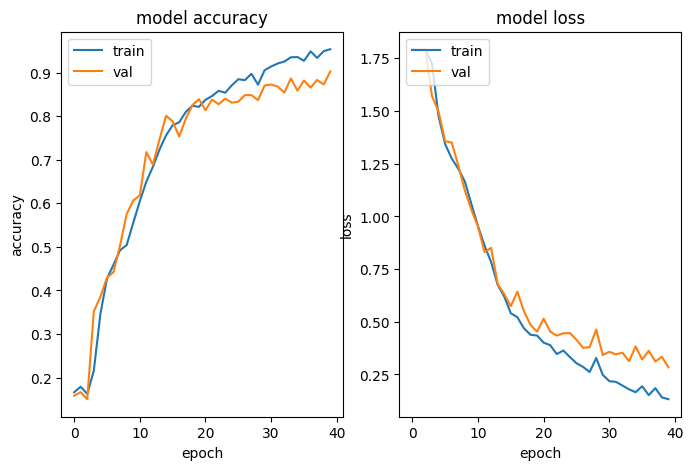

In [85]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 5))

# history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

# history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

The charts show that the train accuracy is higher tyhan the validation accuracy, and the training loss is lower than the validation loss.  
This obviously means that the model did'nt overfit the validation data, but to test if the model generalizes well, we need to test it on completely new set.

In [ ]:
#CNN.save("CNN_4.h5")

# Model Evaluation

In order to evaluate the performance of the model, we load a the test set which consists of a completely new dataset that was not used in training.

In [80]:
f = h5py.File(join(path, 'test_signs.h5'), 'r')
list(f.keys())

['list_classes', 'test_set_x', 'test_set_y']

We perform the same pre-processing either on the images (*normalization*) or on the labels (*one hot encoding* using the same ohe model used earlier).

In [81]:
x_tmp = np.array(f['test_set_x'])
y_tmp = np.array(f['test_set_y'])

In [82]:
x_test = x_tmp/255.0

In [83]:
y_tmp2 = np.expand_dims(y_tmp, axis =1)
y_test = ohe.transform(y_tmp2).toarray()

We then evaluate the model accuracy on the test data

In [84]:
preds = CNN.evaluate(x_test, y_test)
print ("Test Accuracy = {0:.2f} %".format(preds[1]*100))

4/4 [==============================] - 0s 25ms/step - loss: 0.1329 - accuracy: 0.9667
Test Accuracy = 96.67 %


The model shows very good accuracy on test set, proving that the model generlizes well

# Test in live

For this part we will need to use OpenCV to exploit the live Camera feed and save video. To make it easy we will slow the feed and resize the frames in 64x64 in order to use them on the CNN model. We will also slow the feed so that the model can 

In [89]:
import cv2
import time

In [33]:
#CNN = keras.models.load_model("CNN_4.h5")

In [90]:
cap = cv2.VideoCapture(0)
#cap.set(3,64)
#cap.set(4,64)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output5.avi", fourcc, 20.0, (640, 480))

while True:
    time.sleep(0.2)
    ret, frame = cap.read()
    if ret :
        
        # transformation de l'image
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_rsz = cv2.resize(frame_rgb, (64,64) , interpolation = cv2.INTER_AREA)/255.0
        img_rgb_2 = np.expand_dims(im_rsz, axis =0)
        
        
        # prediction
        pred = CNN.predict(img_rgb_2)
        result = pred.argmax()
        
        # print
        #clear_output(wait=True)
        #print(result)
        #print(frame.shape)
        
        # frame 2
        cv2.putText(frame, str(result), org = (10,70), fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale = 3, color=(255,255,255))
        cv2.imshow("Geste", frame)
        
        out.write(frame)
    
    #cv2.imshow("frame", frame)
    key = cv2.waitKey(1)
    if key == 27: # Esc 
        break
        
out.release()
        
cap.release()

cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step
